# Amplitude-based kNN for 2 dimensional vectors

We will start with quantum states composed of 2 qubits, then we will generalise the process for N qubits

In [899]:
import qiskit;
# qiskit.__qiskit_version__

In [900]:
from qiskit import IBMQ;

In [901]:
import numpy as np
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram

In [902]:
# The multi-controlled RY is not included in the standard gates
import qiskit.aqua.circuits.gates.controlled_ry_gates

# Initial state preparation

The algorithm starts with the assumption that the following initial state can be constructed from $M$ training vectors with $N$ entries: 
$$|\psi_0> = \frac{1}{\sqrt{2M}} \sum_{m=1}^M \big(|0>|\psi_x> + |1>|\psi_{t^m}>\big) |c^m> |m> $$

$$|\chi_0> = |a> |d> |c> |m> = |00>|00>|0>|0>$$

In [903]:
# Build the base circuit
knna = QuantumRegister(1, 'knna') # Ancilla for kNN
qrama = QuantumRegister(3, 'qrama') # Ancilla for QRAM
d = QuantumRegister(2, 'd') # vettori del kNN
r = QuantumRegister(1, 'r') # Rotation register for QRAM
c = QuantumRegister(1, 'class') # classe del kNN
m = QuantumRegister(1, 'm') # indice del kNN
classical = ClassicalRegister(3, 'classic') # registri classici
circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)

The sum over $m$ is introduced by simply acting an H gate on the $m$ qubit
$$|\chi_1> = (\mathbb{1} \otimes \mathbb{1} \otimes \mathbb{1} \otimes H) |0>|0>|0>|0> = \frac{1}{\sqrt{2}} \sum_{m=0}^1 |0>|0>|0>|m>$$

In [904]:
circuit.h(m)

Using another H gate, the ancilla qubit is put in superposition: 
$$|\chi_2> = (H \otimes \mathbb{1} \otimes \mathbb{1} \otimes \mathbb{1}) |\chi_1> = \frac{1}{2} \sum_{m=0}^1 \big[|0>|0> + |1>|0>\big]|0>|m>$$

In [905]:
circuit.h(knna)

Next, the input vector $|\psi_x>$ should be loaded into the quantum state by means of QRAM construction
$$|\chi_3> = QRAM(x) |\chi_2>$$

In [906]:
# Put |d> in superposition
circuit.h(d)

In [907]:
inputVector = [np.pi,0,0,0] # Classical data vector with max at π
# I need to normalize to one the input vector
# normalized_input_vector = input_vector
# normalized_input_vector

In [908]:
# Begin QRAM state construction for two qubit data
psixCircuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψx state to the |0> state of the kNN ancilla
# Encode state |00>
psixCircuit.x(d)
# The rotation angle should be converted accordingly: the max should be mapped to π
psixCircuit.mcry(inputVector[0], d[0:2] + knna[0:1], r[0], qrama)
psixCircuit.x(d)
psixCircuit.barrier()
# Encode state |01>
psixCircuit.x(d[0])
psixCircuit.mcry(inputVector[1], d[0:2] + knna[0:1], r[0], qrama)
psixCircuit.x(d[0])
psixCircuit.barrier()
# Encode state |10>
psixCircuit.x(d[1])
psixCircuit.mcry(inputVector[2], d[0:2] + knna[0:1], r[0], qrama)
psixCircuit.x(d[1])
psixCircuit.barrier()
# Encode state |11>
psixCircuit.mcry(inputVector[3], d[0:2] + knna[0:1], r[0], qrama)
psixCircuit.barrier()
# Switch entanglement with ancilla to |a> = |0>
psixCircuit.x(knna)
# psixCircuit.draw(output='mpl')

In [909]:
circuit += psixCircuit

$$|\chi_3> = \frac{1}{2} \sum_{m=0}^1 \big[ |0>|\psi_x> + |1>|00> \big] |0> |m>$$

The next step is to entangle the first training vector $|\psi_{t^0}>$ with the $|1>$ state of the ancilla and the $|0>$ state of the $m$ qubit. Additionally, the second training vector $\psi_{t^1}$ should be entangled with the $|1>$ states of the ancilla and of the $m$ qubit. 

In [910]:
trainingVector0 = [np.pi,0,0,0]
# Entangled with |c> = |0>

In [911]:
circuit.h(c)

In [912]:
# Begin QRAM state construction for two qubit data
psit0Circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψt0 state to the |1> state of the kNN ancilla, to the |0> state of m and to the |0> state of c
# Do I need to superposition |d> again? I don't think so
# I also need to entangle the class of the training vector; that should be encoded in the classical vector
# Encode state |00>
psit0Circuit.x(d)
psit0Circuit.mcry(trainingVector0[0], d[0:2] + knna[0:1] + m[0:1] + c[0:1], r[0], qrama)
psit0Circuit.x(d)
psit0Circuit.barrier()
# Encode state |01>
psit0Circuit.x(d[0])
psit0Circuit.mcry(trainingVector0[1], d[0:2] + knna[0:1] + m[0:1] + c[0:1], r[0], qrama)
psit0Circuit.x(d[0])
psit0Circuit.barrier()
# Encode state |10>
psit0Circuit.x(d[1])
psit0Circuit.mcry(trainingVector0[2], d[0:2] + knna[0:1] + m[0:1] + c[0:1], r[0], qrama)
psit0Circuit.x(d[1])
psit0Circuit.barrier()
# Encode state |11>
psit0Circuit.mcry(trainingVector0[3], d[0:2] + knna[0:1] + m[0:1] + c[0:1], r[0], qrama)
psit0Circuit.barrier()
# Switch entanglement with m to |m> = |0>
psit0Circuit.x(m)
# Switch entanglement with c to |c> = |0>
psit0Circuit.x(c)
# psit0Circuit.draw(output='mpl')

In [913]:
circuit += psit0Circuit

In [914]:
trainingVector1 = [0,np.pi,0,0]
# Entangled with |c> = |1>

In [915]:
# Begin QRAM state construction for two qubit data
psit1Circuit = QuantumCircuit(knna,qrama,d,r,c,m,classical)
# I need to entangle the ψt1 state to the |1> state of the kNN ancilla, to the |1> state of m and to the |1> state of c
# Encode state |00>
psit1Circuit.x(d)
psit1Circuit.mcry(trainingVector1[0], d[0:2] + knna[0:1] + m[0:1] + c[0:1], r[0], qrama)
psit1Circuit.x(d)
psit1Circuit.barrier()
# Encode state |01>
psit1Circuit.x(d[0])
psit1Circuit.mcry(trainingVector1[1], d[0:2] + knna[0:1] + m[0:1] + c[0:1], r[0], qrama)
psit1Circuit.x(d[0])
psit1Circuit.barrier()
# Encode state |10>
psit1Circuit.x(d[1])
psit1Circuit.mcry(trainingVector1[2], d[0:2] + knna[0:1] + m[0:1] + c[0:1], r[0], qrama)
psit1Circuit.x(d[1])
psit1Circuit.barrier()
# Encode state |11>
psit1Circuit.mcry(trainingVector1[3], d[0:2] + knna[0:1] + m[0:1] + c[0:1], r[0], qrama)
psit1Circuit.barrier()
# psit1Circuit.draw(output='mpl')

In [916]:
circuit += psit1Circuit

The desired input and training state is obtained after post-selecting the measurement outcome $|1>_R$ on the register qubit.

In [917]:
circuit.measure(r,classical[0])

Having prepared the initial state $|\psi_0>$ one has to simply apply an H gate to the ancilla qubit. This causes the aplitudes of $|\psi_x>$ and $|\psi_{t^m}>$ to interfere. In this case, constructive ($+$) interference happens when the ancilla qubit is $|0>$ and destructive ($-$) interference when the ancilla is $|1>$. 

In [918]:
circuit.h(knna)
circuit.measure(knna,classical[1])

After the successful conditional measurement, the state is proportional to:
$$|\psi_2> = \frac{1}{2\sqrt{M}} \sum_{m=0}^1 \sum_{i=0}^3 (x_i + t_i^m) |0> |i> |c^m> |m>$$

The probability of measuring e.g. class $|1>$ (B) is then given by the following expression:
$$\text{Prob}(|c^m> = |1(\text{B})>) = \sum_{m|c^m=1(\text{B})} 1 - \frac{1}{4M} \sum_{i=0}^3 |x_i - t_i^m|^2$$

In [919]:
circuit.measure(c,classical[2])

In [942]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=2048)
result = job.result()
counts = result.get_counts(circuit)
# print("\nTotal counts are:",counts)

In [943]:
goodCounts = {k: counts[k] for k in counts.keys() & {'001', '101'}}
# goodCounts

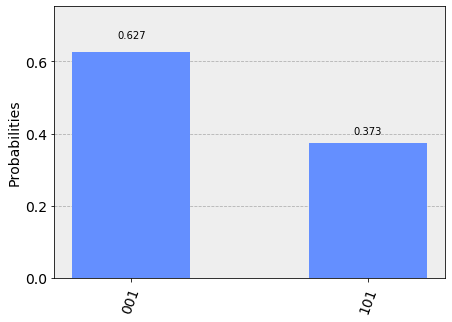

In [944]:
plot_histogram(goodCounts)

In [923]:
# # Testing QRAM
# inputVector = [np.pi,np.pi,np.pi,0]
# qram = QuantumCircuit(qrama,d,r,classical)
# # I need to entangle the ψx state to the |0> state of the kNN ancilla
# qram.h(d)
# # Encode state |00>
# qram.x(d)
# # The rotation angle should be converted accordingly
# qram.mcry(inputVector[0], d[0:2], r[0], qrama)
# qram.x(d)
# qram.barrier()
# # Encode state |01>
# qram.x(d[0])
# qram.mcry(inputVector[1], d[0:2], r[0], qrama)
# qram.x(d[0])
# qram.barrier()
# # Encode state |10>
# qram.x(d[1])
# qram.mcry(inputVector[2], d[0:2], r[0], qrama)
# qram.x(d[1])
# qram.barrier()
# # Encode state |11>
# qram.mcry(inputVector[3], d[0:2], r[0], qrama)
# qram.barrier()
# # qram.draw(output='mpl')
# qram.measure(r,classical[0])
# simulator = Aer.get_backend('qasm_simulator')
# job = execute(qram, simulator, shots=2000)
# result = job.result()
# counts = result.get_counts(qram)
# print("\nTotal counts are:",counts)